In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 

/rds/general/user/mg219/home/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: R2018a is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


In [2]:
ddrtree_data = pd.read_csv("../prevafecg_op_unique_tree_proj_complete_outcomes.csv")
ukb_data = pd.read_csv("../ukb_af_data.csv")

/rds/general/user/mg219/home/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (28,33,113,617) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Visualising pseudotime in BIDMC AF DDRTree

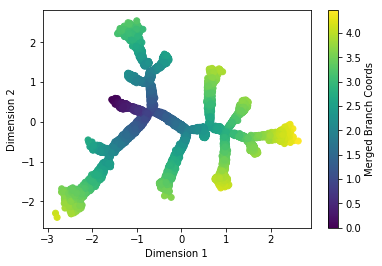

In [3]:

plt.scatter(ddrtree_data['Z1'], ddrtree_data['Z2'], c=ddrtree_data['Pseudotime'])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.colorbar(label='Merged Branch Coords')

plt.show()


# Selecting the VAE features from the BIDMC and UKB AF cohorts

In [4]:
# Z1
X = ddrtree_data[['X20', 'X42', 'X41', 'X8', 'X7', 'X22', 'X50',
       'X40', 'X31', 'X29', 'X21', 'X2', 'X4', 'X17', 'X38', 'X37', 'X35',
       'X16', 'X43', 'X6', 'X30', 'X33', 'X15', 'X9', 'X18', 'X19', 'X23',
       'X25', 'X1', 'X12', 'X46', 'X34', 'X45', 'X3', 'X49', 'X39', 'X24',
       'X14', 'X36', 'X10', 'X44', 'X26', 'X28', 'X13', 'X48', 'X11', 'X27',
       'X47', 'X5', 'X51', 'X32']]
y_Z1 = ddrtree_data[['Z1']]
y_Z2 = ddrtree_data[['Z2']]

X_test = ukb_data[['X20', 'X42', 'X41', 'X8', 'X7', 'X22', 'X50',
       'X40', 'X31', 'X29', 'X21', 'X2', 'X4', 'X17', 'X38', 'X37', 'X35',
       'X16', 'X43', 'X6', 'X30', 'X33', 'X15', 'X9', 'X18', 'X19', 'X23',
       'X25', 'X1', 'X12', 'X46', 'X34', 'X45', 'X3', 'X49', 'X39', 'X24',
       'X14', 'X36', 'X10', 'X44', 'X26', 'X28', 'X13', 'X48', 'X11', 'X27',
       'X47', 'X5', 'X51', 'X32']]

## Splitting the data for Z1 prediction

In [5]:
X_train_z1, X_val_z1, y_train_z1, y_val_z1 = train_test_split(X, y_Z1, test_size=0.25, random_state=42)
print(X_train_z1.shape)
print(X_val_z1.shape)

(15218, 51)
(5073, 51)


After this, we carry out a grid search to apply hyperparameter tuning to both XGBoost models predicting Z1 and Z2. The optimal parameters returned were used for model training.

## Model building to predict Z1

In [7]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assuming X_train_z1, y_train_z1, X_val_z1, y_val_z1 are defined

best_params = {
    'max_depth': 5,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'n_estimators': 200
}


start_time = time.time()
xgb = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)

xgb.fit(X_train_z1, y_train_z1)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60

print(f"The task took {elapsed_minutes:.2f} minutes to run.")

# Evaluate the best model on test set
y_pred_z1 = xgb.predict(X_val_z1)
mse = mean_squared_error(y_val_z1, y_pred_z1)
print("Mean Squared Error on Validation Set:", mse)

# Calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance
rmse = mean_squared_error(y_val_z1, y_pred_z1, squared=False)
print(f"Root Mean Squared Error: {rmse}")

# You need to import r2_score and mean_absolute_error if you want to use them
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_val_z1, y_pred_z1)
print(f"R-squared: {r2}")

mae = mean_absolute_error(y_val_z1, y_pred_z1)
print(f"Mean Absolute Error: {mae}")


The task took 1.93 minutes to run.
Mean Squared Error on Validation Set: 0.2004425883373231
Root Mean Squared Error: 0.447708150849773
R-squared: 0.8598330284552983
Mean Absolute Error: 0.3478914746706048


In [9]:
# make new labels!
start_time = time.time()
y_pred_new_z1 = xgb.predict(X_test)
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60

print(f"The task took {elapsed_minutes:.2f} minutes to run.")

The task took 0.00 minutes to run.


In [35]:
y_pred_new_z1.shape

(2344,)

## Spliting the data for Z2 prediction

In [10]:
X_train_z2, X_val_z2, y_train_z2, y_val_z2 = train_test_split(X, y_Z2, test_size=0.25, random_state=42)
print(X_train_z2.shape)
print(X_val_z2.shape)

(15218, 51)
(5073, 51)


## Model building to predict Z2

In [11]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assuming X_train_z1, y_train_z1, X_val_z1, y_val_z1 are defined

best_params = {
    'max_depth': 5,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'n_estimators': 200
}


start_time = time.time()
xgb = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)

xgb.fit(X_train_z2, y_train_z2)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60

print(f"The task took {elapsed_minutes:.2f} minutes to run.")

# Evaluate the best model on test set
y_pred_z2 = xgb.predict(X_val_z2)
mse = mean_squared_error(y_val_z2, y_pred_z2)
print("Mean Squared Error on Validation Set:", mse)

# Calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance
rmse = mean_squared_error(y_val_z2, y_pred_z2, squared=False)
print(f"Root Mean Squared Error: {rmse}")

# You need to import r2_score and mean_absolute_error if you want to use them
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_val_z2, y_pred_z2)
print(f"R-squared: {r2}")

mae = mean_absolute_error(y_val_z2, y_pred_z2)
print(f"Mean Absolute Error: {mae}")


The task took 1.94 minutes to run.
Mean Squared Error on Validation Set: 0.12109273079805939
Root Mean Squared Error: 0.347983808241216
R-squared: 0.8855043453747042
Mean Absolute Error: 0.2713222082542328


In [12]:
# make new labels!
start_time = time.time()
y_pred_new_z2 = xgb.predict(X_test)
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60

print(f"The task took {elapsed_minutes:.2f} minutes to run.")

The task took 0.00 minutes to run.


In [40]:
y_pred_new_z2.shape

(2344,)

## Distance estimating algorithm

In [13]:
orig_matrix = ddrtree_data[['Z1', 'Z2']].to_numpy()
y_pred_new_z1 = y_pred_new_z1.reshape(-1, 1)
y_pred_new_z2 = y_pred_new_z2.reshape(-1, 1)
pred_matrix = np.concatenate((y_pred_new_z1, y_pred_new_z2), axis = 1)
print(orig_matrix.shape)
print(pred_matrix.shape)

(20291, 2)
(2344, 2)


In [14]:
np.save('../external_val/orig_matrix.npy', orig_matrix)
np.save('../external_val/pred_matrix.npy', pred_matrix)

With the computational requirements of the distance estimating algorithm, it was run using the distance_estimation.py script using HPC resources. 

The resulting coordinates were loaded back in this notebook to assign phenogroups to the UKB AF population.

# Predicting phenogroup assignments

In [16]:
new_pred_matrix = np.load("../external_val/new_pred_matrix_xgboost_ukb.npy")
new_pred_df = pd.DataFrame(data=new_pred_matrix, columns=['Z1', 'Z2'])
result = pd.concat([ukb_data, new_pred_df], axis=1)

print(ddrtree_data.shape)
print(ukb_data.shape)

X = ddrtree_data[['Z1', 'Z2']]
y = ddrtree_data['merged_branchcoords'].values.flatten()
X_test = result[['Z1', 'Z2']]

y.shape

(20291, 630)
(2344, 173)


(20291,)

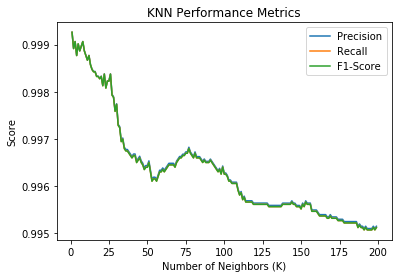

In [19]:
kfold = KFold(n_splits=10) 
k_range = range(1, 200)

precision_scores = []
recall_scores = []
f1_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_validate for KNeighborsClassifier with k neighbors
    scoring = {
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted')
    }
    scores = cross_validate(knn, X, y, cv=kfold, scoring=scoring)
    
    # 4. append the scores to the lists
    precision_scores.append(np.mean(scores['test_precision']))
    recall_scores.append(np.mean(scores['test_recall']))
    f1_scores.append(np.mean(scores['test_f1_score']))
    


# 5. Plot the metrics across different K values
plt.plot(k_range, precision_scores, label='Precision')
plt.plot(k_range, recall_scores, label='Recall')
plt.plot(k_range, f1_scores, label='F1-Score')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Score')
plt.title('KNN Performance Metrics')
plt.legend()
plt.show()


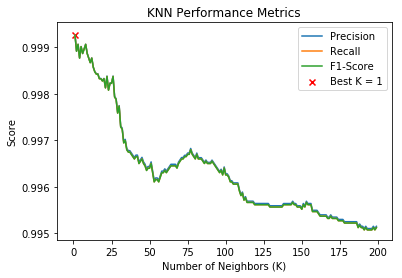

In [20]:
best_k_index = np.argmax(f1_scores)
best_k = k_range[best_k_index]
best_f1_score = f1_scores[best_k_index]

# 5. Plot the metrics across different K values
plt.plot(k_range, precision_scores, label='Precision')
plt.plot(k_range, recall_scores, label='Recall')
plt.plot(k_range, f1_scores, label='F1-Score')
plt.scatter(best_k, best_f1_score, color='red', marker='x', label=f'Best K = {best_k}')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Score')
plt.title('KNN Performance Metrics')
plt.legend()

plt.gcf().set_size_inches(6, 4)  

plt.savefig('/rds/general/user/mg219/home/mg219/clean_scripts_RA/scripts/af_ddrtree/af_unique/external_val/knn_performance_branch.png', dpi=300, bbox_inches='tight')  # Save as PNG file with DPI 600 and tight bounding box

plt.show()


In [21]:

best_k_index = np.argmax(f1_scores)
best_k = k_range[best_k_index]

print(f"The best value of k according to F1 is: {best_k}")

best_k_index = np.argmax(precision_scores)
best_k = k_range[best_k_index]

print(f"The best value of k according to Precision is: {best_k}")

best_k_index = np.argmax(recall_scores)
best_k = k_range[best_k_index]

print(f"The best value of k according to Recall is: {best_k}")

The best value of k according to F1 is: 1
The best value of k according to Precision is: 1
The best value of k according to Recall is: 1


In [22]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X,y)

y_test = knn.predict(X_test)

columns_from_df = X_test.values
y_test_reshaped = y_test[:, np.newaxis]  # or y_test.reshape(-1, 1)

pred_coords_branches = np.concatenate((columns_from_df, y_test_reshaped), axis=1)
pred_coords_branches.shape
np.save('../external_val/pred_coords_branches_xgboost_knn.npy', pred_coords_branches)


KNeighborsClassifier(n_neighbors=1)